# Getting data from COCA corpus

In [1]:
import pandas as pd
import zipfile
import re
import os
import matplotlib
import matplotlib.pyplot as plt 

In [2]:
# set filepath
COCA = "/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/Data/Davies Corpora/COCA/"
COCA

'/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/Data/Davies Corpora/COCA/'

## Getting texts

In [3]:
def get_data(corpus, topic_filter):    
    # get all text
    data = load_corpus(corpus)    
    all_news = []
    [all_news.extend(data[k]) for k in data.keys()]
        
    # load into dataframe
    df = pd.DataFrame(all_news, columns=['text'])
    df['text'] = df.apply(lambda x: x['text'].decode('utf-8', errors='ignore'), axis=1) 
    df['text'] = df['text'].apply(lambda x: x.lower())
    df = df[df['text']!='\r\n']
    df = df[df['text'].str.contains(topic_filter)]

    # get text_ids
    df['text_id'] = df.apply(lambda x: get_textid(x), axis=1)
    df.set_index('text_id', inplace=True)
    return df

def get_textid(row):
        text = row['text']
        text_id = re.search('(?<=##|@@)[0-9]+', text)
        return str(text_id.group(0))
    
def load_corpus(corpus):
    data = {}
    for zip_ in os.listdir(corpus):
        if "zip" in zip_ and "sources" not in zip_:
            try:
                zfile = zipfile.ZipFile(corpus + zip_)
                for file in zfile.namelist():
                    data[file] = []
                    with zfile.open(file) as f:
                        for line in f:
                            data[file].append(line)
            except:
                print(zip_, " ")
                continue

    return data

In [4]:
df = get_data(COCA, '')
# total of 219,379 articles

In [5]:
refugee_df = get_data(COCA, 'refugee')

In [6]:
refugee_df
# 5,476

,text
text_id,
2018849,"##2018849 <p> "" bums . "" that 's what radio ha..."
2018850,##2018850 section : investing <p> expanding pe...
2019006,##2019006 section : clothes that work american...
2019061,##2019061 section : movements from socialist t...
2019063,##2019063 <p> inside a dusty cement-block hous...
...,...
4162833,@@4162833 o o . here i am with this american b...
4162845,"@@4162845 atrick is fourteen , this is earth ,..."
4162876,@@4162876 any future lists of colorful texas c...


## Getting metadata

In [7]:
def get_sources():
    cols = ['text_id', 'word_count', 'year', 'genre', 'subgen', 'source', 'title', 'publication_info']

    zfile = zipfile.ZipFile(COCA + "sources.zip")
    source = []
    for file in zfile.namelist():
        with zfile.open(file) as f:
            i=0
            for line in f:
                if i<=1:
                    # skip first 2 lines
                    print(line)
                    i+=1
                    continue
               
                line = line.decode('utf-8', errors='ignore').split("\t", 7)
                if len(line)>4:
                    source.append(line)
    
    sources_df = pd.DataFrame(source, columns=cols)
    sources_df.set_index('text_id', inplace=True)
    return sources_df

In [8]:
sources_df = get_sources()

b'textID\t#words\tyear\tgenre\tsubgen\tsource\ttitle\t\t(publication info, for non-spoken)\r\n'
b'----\t----\t----\t----\t----\t----\t----\r\n'


In [9]:
sources_df
#248,948 sources

,word_count,year,genre,subgen,source,title,publication_info
text_id,,,,,,,
221118,8101,1990,SPOK,101,ABC_20/20,Is He a Killer?; Who Will Love My Pet?; The Tw...,None
221119,8358,1990,SPOK,101,ABC_20/20,Golden Years Behind Bars; The Joker; Goodbye W...,None
221120,7824,1990,SPOK,101,ABC_20/20,Too Old Too Soon; Danger on the Half Shell; Mi...,None
221121,8559,1990,SPOK,101,ABC_20/20,Chicken at Any Price?; The Daytop Solution; Su...,None
221122,8199,1990,SPOK,101,ABC_20/20,Children of Terror; Against All Odds; Buck Fev...,None
...,...,...,...,...,...,...,...
4174366,993,2017,ACAD,NULL,Inside Higher Ed,Study details tool to help professors measure ...,None
4174367,2393,2017,ACAD,NULL,Diverse: Issues in Higher Education,Experts: Colleges' Media Messages Need Diverse...,None
4174368,1034,2017,ACAD,NULL,Inside Higher Ed,Another Year on the Academic Job Market\r\n,None


## Merge text and meta data

In [10]:
# only take articles that have both text and metadata
refugee_merged_df = refugee_df.join(sources_df, how='inner')
all_merged_df = df.join(sources_df, how='inner')

refugee_merged_df['year'] = refugee_merged_df['year'].apply(int)
refugee_merged_df['word_count'] = refugee_merged_df['word_count'].apply(int)
all_merged_df['year'] = all_merged_df['year'].apply(int)
all_merged_df['word_count'] = all_merged_df['word_count'].apply(int)

In [11]:
print(len(refugee_merged_df), len(all_merged_df))

5475 219337


In [12]:
refugee_merged_df.groupby('year').size()
# about 200 a year

year
1990    252
1991    308
1992    235
1993    268
1994    281
1995    204
1996    210
1997    166
1998    192
1999    235
2000    228
2001    213
2002    266
2003    200
2004    188
2005    193
2006    231
2007    193
2008    153
2009    170
2010    146
2011    183
2012    166
2013    158
2014    204
2015    232
dtype: int64

In [13]:
refugee_merged_df.groupby('genre').size()

genre
ACAD     921
FIC      562
MAG     1003
NEWS    1675
SPOK    1314
dtype: int64

In [14]:
refugee_merged_df.groupby('year').size()/all_merged_df.groupby('year').size()*100

year
1990    3.888889
1991    4.657493
1992    3.328612
1993    3.698592
1994    3.849842
1995    2.768354
1996    2.895753
1997    2.103129
1998    2.396705
1999    2.866553
2000    2.441375
2001    2.484834
2002    2.868852
2003    2.045617
2004    2.018900
2005    2.147308
2006    2.516614
2007    2.133068
2008    1.774324
2009    1.918519
2010    1.618805
2011    1.807050
2012    1.704137
2013    1.870708
2014    2.313712
2015    2.637862
dtype: float64

## Data cleaning

In [62]:
data = refugee_merged_df.reset_index()

In [64]:
data

,text_id,text,word_count,year,genre,subgen,source,title,publication_info
0,2018849,"##2018849 <p> "" bums . "" that 's what radio ha...",2950,1990,MAG,124,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n"
1,2018850,##2018850 section : investing <p> expanding pe...,2514,1990,MAG,124,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n"
2,2019006,##2019006 section : clothes that work american...,1667,1990,MAG,130,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n"
3,2019061,##2019061 section : movements from socialist t...,1754,1990,MAG,123,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n"
4,2019063,##2019063 <p> inside a dusty cement-block hous...,6032,1990,MAG,123,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n"
...,...,...,...,...,...,...,...,...,...
5470,4162833,@@4162833 o o . here i am with this american b...,2952,2013,FIC,115,AntiochRev,Beta.,"Spring2013, Vol. 71 Issue 2, p309-316. 8p. \r\n"
5471,4162845,"@@4162845 atrick is fourteen , this is earth ,...",6792,2013,FIC,115,MassachRev,Godzilla versus the Smog Monster.,"Spring2013, Vol. 54 Issue 1, p51-67. 17p. \r\n"
5472,4162876,@@4162876 any future lists of colorful texas c...,7553,2013,FIC,116,FantasySciFi,A Haunting in Love City.,"Jan/Feb2013, Vol. 124 Issue 1/2, p147-165. 19..."
5473,4163095,@@4163095 first met sulayman in a play at the ...,13168,2013,FIC,115,NewEnglandRev,The Damascus Players.,"2013, Vol. 34 Issue 2, p94-118. 25p. \r\n"


In [67]:
import string

def clean_title(row):
    title = row['title']
    remove = ['\r','\n','^']
    for string in remove:
        title = title.replace(string,'')
    return title

def clean_text(row):
    text = row['text']
    text_id = row['text_id']
    remove = ['\r','\n','<p>','##{}'.format(text_id), '@@{}'.format(text_id)]
    for each in remove:
        text = text.replace(each,'')
    return text.translate(str.maketrans('', '', string.punctuation))


In [68]:
data['title'] = data.apply(lambda x: clean_title(x), axis=1)
data['text'] = data.apply(lambda x: clean_text(x), axis=1)

## Summary of Sample

In [72]:
genres = data['genre'].unique()
genres

array(['MAG', 'ACAD', 'SPOK', 'FIC', 'NEWS'], dtype=object)

In [73]:
years = sorted(data['year'].unique())
years

[1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

### Number / percentage of docs

Text(0.5, 1.0, "Number of documents with 'refugee' in the COCA corpus by year")

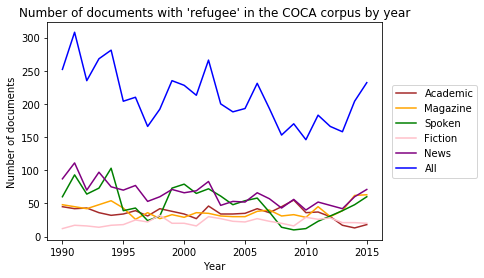

In [74]:
# Number of articles over time by genre
acad, = plt.plot(years, data[data['genre']=='ACAD'].groupby('year').size(), label='Academic')
mag, = plt.plot(years, data[data['genre']=='MAG'].groupby('year').size(), label='Magazine')
spok, = plt.plot(years, data[data['genre']=='SPOK'].groupby('year').size(), label='Spoken')
fic, = plt.plot(years, data[data['genre']=='FIC'].groupby('year').size(), label='Fiction')
news, = plt.plot(years, data[data['genre']=='NEWS'].groupby(['year']).size(), label='News')
all_, = plt.plot(years,data.groupby('year').size(), label="All")

colors = ["brown","orange","green","pink","purple","blue"]
for i in range(len(plt.gca().get_lines())):
    plt.gca().get_lines()[i].set_color(colors[i])
    
plt.legend(handles=[acad, mag, spok, fic, news, all_], loc="center right", bbox_to_anchor=(1.3, .5), ncol=1)


plt.ylabel('Number of documents')
plt.xlabel('Year')
plt.title("Number of documents with 'refugee' in the COCA corpus by year")

Text(0.5, 1.0, "Percentage of documents with 'refugee' in the COCA corpus by year")

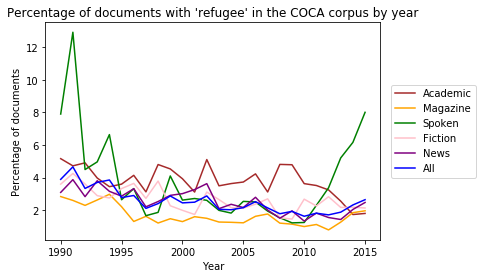

In [75]:
# Percentage of articles over time by genre

acad, = plt.plot(years, data[data['genre']=='ACAD'].groupby('year').size()/all_merged_df[all_merged_df['genre']=='ACAD'].groupby('year').size()*100, label='Academic')
mag, = plt.plot(years, data[data['genre']=='MAG'].groupby('year').size()/all_merged_df[all_merged_df['genre']=='MAG'].groupby('year').size()*100, label='Magazine')
spok, = plt.plot(years, data[data['genre']=='SPOK'].groupby('year').size()/all_merged_df[all_merged_df['genre']=='SPOK'].groupby('year').size()*100, label='Spoken')
fic, = plt.plot(years, data[data['genre']=='FIC'].groupby('year').size()/all_merged_df[all_merged_df['genre']=='FIC'].groupby('year').size()*100, label='Fiction')
news, = plt.plot(years, data[data['genre']=='NEWS'].groupby('year').size()/all_merged_df[all_merged_df['genre']=='NEWS'].groupby('year').size()*100, label='News')
all_, = plt.plot(years, data.groupby('year').size()/all_merged_df.groupby('year').size()*100, label="All")

colors = ["brown","orange","green","pink","purple","blue"]
for i in range(len(plt.gca().get_lines())):
    plt.gca().get_lines()[i].set_color(colors[i])
    
plt.legend(handles=[acad, mag, spok, fic, news, all_], loc="center right", bbox_to_anchor=(1.3, .5), ncol=1)

plt.ylabel('Percentage of documents')
plt.xlabel('Year')
plt.title("Percentage of documents with 'refugee' in the COCA corpus by year")

### Average word count

In [76]:
# Average Word Count
data['word_count'].sum() / len(data)

4390.767305936073

In [77]:
print(data['word_count'].min(), data['word_count'].max())

44 107449


In [78]:
def get_word_count(data):
    word_count = []
    for yr in years:
        yearly = data[data['year']==yr]
        word_count.append(yearly['word_count'].sum() / len(yearly))
    return word_count

Text(0.5, 1.0, "Average word count of documents with 'refugee' in the COCA corpus by year")

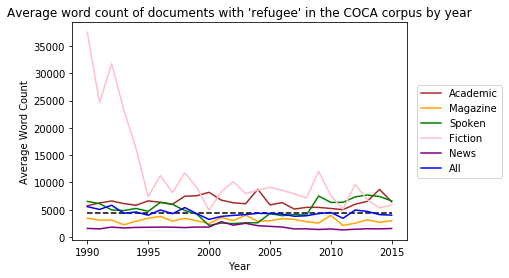

In [79]:
acad, = plt.plot(years, get_word_count(data[data['genre']=='ACAD']), label='Academic')
mag, = plt.plot(years, get_word_count(data[data['genre']=='MAG']), label='Magazine')
spok, = plt.plot(years, get_word_count(data[data['genre']=='SPOK']), label='Spoken')
fic, = plt.plot(years, get_word_count(data[data['genre']=='FIC']), label='Fiction')
news, = plt.plot(years, get_word_count(data[data['genre']=='NEWS']), label='News')
all_, = plt.plot(years, get_word_count(data), label='All')

colors = ["brown","orange","green","pink","purple","blue"]
for i in range(6):
    plt.gca().get_lines()[i].set_color(colors[i])
    
plt.legend(handles=[acad, mag, spok, fic, news, all_], loc="center right", bbox_to_anchor=(1.3, .5), ncol=1)

# plot average of sample
plt.hlines(data['word_count'].sum() / len(data), 1990, 2015, linestyles='dashed')

plt.ylabel('Average Word Count')
plt.xlabel('Year')
plt.title("Average word count of documents with 'refugee' in the COCA corpus by year")

### Unique sources

In [80]:
# Number of unique sources over time
def get_unique_source(data):
    unique_source = []
    for yr in years:
        yearly = data[data['year']==yr]
        unique_source.append(len(yearly['source'].unique()))
    return unique_source

In [81]:
len(data['source'].unique())

621

In [82]:
years[-1]

2015

Text(0.5, 1.0, "Number of unique sources with 'refugee' in the COCA corpus by year")

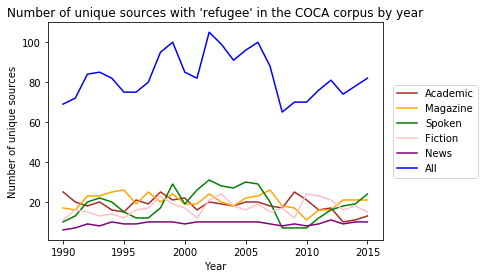

In [83]:
acad, = plt.plot(years, get_unique_source(data[data['genre']=='ACAD']), label='Academic')
mag, = plt.plot(years, get_unique_source(data[data['genre']=='MAG']), label='Magazine')
spok, = plt.plot(years, get_unique_source(data[data['genre']=='SPOK']), label='Spoken')
fic, = plt.plot(years, get_unique_source(data[data['genre']=='FIC']), label='Fiction')
news, = plt.plot(years, get_unique_source(data[data['genre']=='NEWS']), label='News')
all_, = plt.plot(years, get_unique_source(data), label='All')

colors = ["brown","orange","green","pink","purple","blue"]
for i in range(6):
    plt.gca().get_lines()[i].set_color(colors[i])
    
plt.legend(handles=[acad, mag, spok, fic, news, all_], loc="center right", bbox_to_anchor=(1.3, .5), ncol=1)

plt.ylabel('Number of unique sources')
plt.xlabel('Year')
plt.title("Number of unique sources with 'refugee' in the COCA corpus by year")

## Getting only relevant genres for analysis

In [84]:
data = data[(data['genre']=='SPOK') | (data['genre']=='NEWS') | (data['genre']=='MAG')]

In [85]:
data.genre.unique()

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

In [86]:
len(data)

3992

In [87]:
data.to_csv('data/refugee_coca_foranalysis.csv', index=False)